# New ts_gen

In [1]:
import torch
torch.cuda.empty_cache()

In [2]:
from utils.meta_eval import TSGenArgs, create_ds_dict, plot_ds
from experiments.meta_eval.me import experiment

args = TSGenArgs()
args.n_epochs = 100
args.test_interval = 100
args.gnn_depth = 1
args.n_layers = 1
# args.remove_existing_data = True

exp_log = experiment(args)

Starting training...
Starting training...
100%|██████████| 843/843 [00:24<00:00, 35.01it/s]
Epoch 1: Training Loss 0.19120346294008758
Epoch 1: Training Loss 0.19120346294008758
100%|██████████| 843/843 [00:22<00:00, 37.62it/s]
Epoch 2: Training Loss 0.18268719935437322
Epoch 2: Training Loss 0.18268719935437322
100%|██████████| 843/843 [00:22<00:00, 38.15it/s]
Epoch 3: Training Loss 0.18153796892905114
Epoch 3: Training Loss 0.18153796892905114
100%|██████████| 843/843 [00:21<00:00, 38.74it/s]
Epoch 4: Training Loss 0.1803865752120965
Epoch 4: Training Loss 0.1803865752120965
100%|██████████| 843/843 [00:22<00:00, 38.13it/s]
Epoch 5: Training Loss 0.17983264920349176
Epoch 5: Training Loss 0.17983264920349176
100%|██████████| 843/843 [00:22<00:00, 38.22it/s]
Epoch 6: Training Loss 0.17843247811374577
Epoch 6: Training Loss 0.17843247811374577
100%|██████████| 843/843 [00:22<00:00, 37.85it/s]
Epoch 7: Training Loss 0.17659690958110602
Epoch 7: Training Loss 0.17659690958110602
100%|███

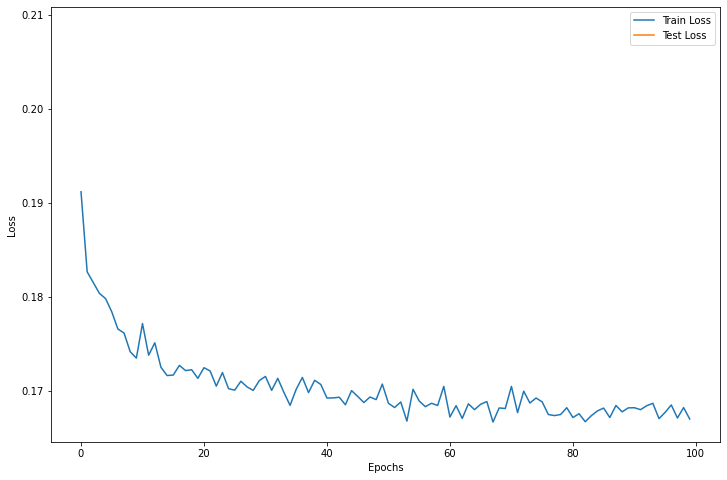

In [5]:
import numpy as np

def save_Ds(exp_log, file_name, save_to_log_dir = False, D_folder='experiments/meta_eval/d_inits/'):
    test_Ds = np.concatenate(exp_log.test_logs[-1].Ds, 0)[0:842] # final test log, new dim = num_rxns x 21 x 21
    assert len(test_Ds) == 842, f"Should have 842 test_D_inits when unbatched, you have {len(test_Ds)}."
    np.save(D_folder + file_name, test_Ds)
    if save_to_log_dir:
        np.save(exp_log.args.log_dir + 'D', test_Ds)

def save_Ws(exp_log, file_name, save_to_log_dir = False, W_folder='experiments/meta_eval/ws/'):
    test_Ws = np.concatenate(exp_log.test_logs[-1].Ws, 0)[0:842].squeeze() # final test log, and remove singleton dims; new dim = num_rxns x 21 x 21
    assert len(test_Ws) == 842, f"Should have 842 test_Ws when unbatched, you have {len(test_Ws)}."
    np.save(W_folder + file_name, test_Ws)
    if save_to_log_dir:
        np.save(exp_log.args.log_dir + 'W', test_Ws)

file_name = '8.npy'
save_Ds(exp_log, file_name, save_to_log_dir=True)
save_Ws(exp_log, file_name, True)
exp_log.plot_loss(save_fig = True)

In [3]:
file_name = '8.npy'
#exp_log.save_Ds(file_name, save_to_log_dir=True)
#exp_log.save_Ws(file_name, save_to_log_dir=True)
# exp_log.plot_loss(save_fig = True)

AssertionError: Should have 842 test_D_inits when unbatched, you have 1684.

/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/anaconda/envs/3d-rdkit/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with si

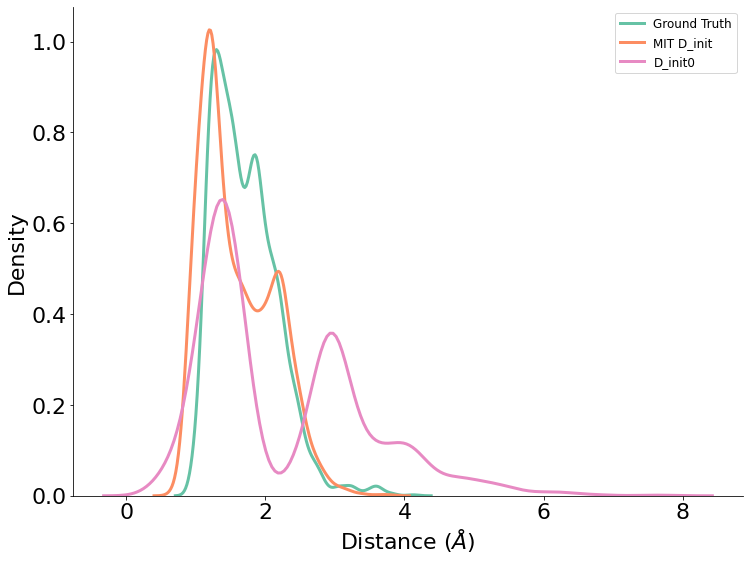

In [6]:
import os

# create ds_dict and plot d_inits
mols_folder = 'data/raw/'
d_folder = 'experiments/meta_eval/d_inits/'

d_plot_name = os.path.join(os.path.dirname(args.log_dir), 'dplot') # None won't save fig
# b/d/n=standard; h=32 1(e=20), 2(e=30)
# standard: 1(e=100,t=2500s), 3(e=10, t=400s), 4(e=30, t=1200s), 5(e=50, t=1900s), 6(e=100, t=3850s)
# 09/08: 9(e=100,t=3900), 10(e=100,t=3580)
# 09/08 no opt: 8(e=100, t=2400)
d_files = ['8.npy'] 
ds_not_to_print = ['lin_approx']
ds_dict = create_ds_dict(d_files, d_folder, mols_folder) # TODO: create default d_init class for these?
plot_ds(ds_dict, ds_not_to_print, d_plot_name)

## Ensemble

Average all produced $D_{inits}s$ then plot.

In [ ]:
from utils.meta_eval import ensemble_plot

d_files = ['1.npy', '6.npy'] 
ds_dict = create_ds_dict(d_files, d_folder, mols_folder)
ds_not_to_print = ['lin_approx']

ensemble_plot(ds_dict, ds_not_to_print)

ImportError: cannot import name 'ensemble_plot'